# Modélisation du système bactérie/anticorps

Nadir Ait Kheddache, Idriss Alaoui Souliman, Fabien Benthami, Alma Draeger, Alexandre Janin

In [2]:
#Imports
import numpy as np
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation
import IPython
from IPython.display import HTML

In [3]:
#Variables globales

#Couleurs
cmap = ListedColormap(['white', 'lightpink', 'lightblue', 'lightgrey'])

#Infini
infini = False

#True: les gb apparaissent toujours a coté d'une bactérie
gb_apparait_sur_bacterie = True

#probabilité d'avoir chaque type de cellule (0: vide, 1: bactérie, 2: globule blanc, 3: nutriments)
#la somme des probabilités doit être égale à 1
proba = [0.7, 0.1, 0, 0.2]

#probabilité qu'une cellule vide se transforme en nutriments
proba_apparition_nutriments = 0.04

#nombre de GB nécessaires pour tuer une bactérie
nb_gb_necessaires = 2

#nombre de gb qui apparait par bacterie à chaque étape
gb_par_bact = 0.1

#temps de survie des bactéries sans nutriments
t_survie_b = 10

#temps de survie des gb
t_survie_gb = 8

#temps de survie des nutriments
t_survie_n = 2

#Symbole qui représente chaque valeur de cellule
cara = ['-', 'B', 'G', 'n']

In [4]:
def matrice(l, h, vide = False):
    """ int^2 -> int[][]
    largeur > 0, hauteur > 0
    Renvoie une matrice de 0 de l colonnes et h lignes"""
    
    if(vide):  
        return [[0 for x in range(l)] for y in range(h)]
    else:
        return [[aleatoire() for x in range(l)] for y in range(h)]

In [5]:
def aleatoire():
    """float -> int
    Renvoie le type de cellule (0, 1, 2, 3) selon le nombre aléatoire tiré"""
    
    alea = np.random.rand()
    
    for i in range(len(proba)):
        p = proba[i]
        if alea <= p:
            return i
        else:
            alea -= p
            
    return 0

In [6]:
def printmatrice(M, T):
    """int[][] -> NoneType
    Affiche la matrice M"""
    IPython.display.clear_output()
    for y in range(len(M)):
        s = ""
        for cell in M[y]:
            s += cara[cell] + ' '
            
        s += '\t'
        for t in T[y]:
            s += str(t) + ' '
        print(s + "\n")
    
    compte = compteur(M)
    
    print("Bactéries: ", compte[1], "\nGlobules blancs: ", compte[2])

In [7]:
def voisinage(M, x, y):
    """int[][] * int * int * bool-> int[]
    Renvoie la liste des voisins de la case (x, y).
    Si infini est False, on ne prend pas les voisins hors de la matrice"""
    v = [0, 0, 0, 0]
    
    ymax = len(M)
    xmax = len(M[0])
    
    for i in [x - 1, x, x + 1]:
        if (0 <= i and i < xmax):
            for j in [y - 1, y, y + 1]:
                if (0 <= j and j < ymax):
                        if (i, j) != (x, y): #Si i, j n'est pas la case centrale
                            v[M[j][i]] += 1
    return v

In [8]:
def next_step_matrice(M, temps):
    """int[][] -> int [][]
    Renvoie la matrice à l'étape suivante."""
    
    nv_M = list(M)
    
    compte = compteur(nv_M)
    
    for y in range(len(M)):
        for x in range(len(M[y])):
            nv_M[y][x] = next_step_cellule(x, y, M, temps)

    reaction_gb(nv_M, int(gb_par_bact * compte[1]) + 1)

    return nv_M

In [9]:
def next_step_cellule(x, y, matrice, t):
    """int * int[] -> int
    Hypothèse: c = 0 ou 1 ou 2 ou 3
    Renvoie l'état suivant d'une cellule c en fonction de son état actuel et de ses voisins."""
    
    c = matrice[y][x]
    
    voisins = voisinage(matrice, x, y)
    
    vides = voisins[0]
    bacteries = voisins[1]
    globules = voisins[2]
    nutriments = voisins[3]
    
    if (c == 0): #La cellule est vide
        if (np.random.rand() <= proba_apparition_nutriments): #Un nutriment apparait
            return 3
        else: #La cellule reste vide
            return 0
        
    if (c == 1): #Bactérie
        if (nutriments >= 1):
            t[y][x] = 0
        else:
            t[y][x] += 1
            if(t[y][x] >= t_survie_b):
                t[y][x] = 0
                return 0
        if (globules >= nb_gb_necessaires): #Les GB tuent la bactérie
            return 0
        else: #La bactérie survit
            return 1
        
    if (c == 2): #Globule blanc
        t[y][x] += 1
        if(t[y][x] >= t_survie_gb):
            t[y][x] = 0
            return 0
        
        return 2
        
    if (c == 3): #Nutriment
        t[y][x] += 1
        if(t[y][x] >= t_survie_n):
            t[y][x] = 0
            return 0
            
        if (bacteries > 0 and globules == 0): #La bactérie voisine se multiplie
            return 1
        else: #La cellule reste un nutriment
            return 3
        
    print("Erreur: c invalide:", c)

In [10]:
def reaction_gb(mat, nb_gb):
    h = len(mat)
    l = len(mat[0])
    
    for i in range(nb_gb):
        essais = 0
        
        while(essais < 100):
            essais += 1
            x = np.random.randint(0, l)
            y = np.random.randint(0, h)
            if((mat[y][x] == 0 or mat[y][x] == 3) and (not gb_apparait_sur_bacterie or voisinage(mat, x, y)[1] > 0)):
                mat[y][x] = 2
                break

In [11]:
def display_next_step(b):
    global mat
    global t
    global button
    global reset_button
    
    mat = next_step_matrice(mat, t)
    printmatrice(mat, t)
    
    display(reset_button)
    display(button)

In [12]:
def reset(b):
    global mat
    global t
    mat = matrice(30, 8)
    t = matrice(30, 8, True)
    printmatrice(mat, t)
    display(reset_button)
    display(button)

In [13]:
reset_button = widgets.Button(
    description='Reset',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me!',
    icon='check'
)

button = widgets.Button(
    description='Next Step',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me!',
    icon='check'
)

button.on_click(display_next_step)
reset_button.on_click(reset)

display(reset_button)
display(button)

Button(button_style='info', description='Reset', icon='check', style=ButtonStyle(), tooltip='Click me!')

Button(button_style='info', description='Next Step', icon='check', style=ButtonStyle(), tooltip='Click me!')

In [14]:
def compteur(mat):
    """int[][] -> (int, int)
    Renvoie le nombre de GB et bactéries dans une matrice"""
    compte = [0, 0, 0, 0]
    for i in mat:
        for j in i:
            compte[j] += 1
    return compte

In [15]:
def simulate_compte(l, h, steps):
    """int * bool -> (int, int, int)
    Renvoie le nombre de GB et bactéries apres steps étapes."""
    
    mat = matrice(l, h)
    
    temps = matrice(l, h, True)
    
    resultsG = []
    resultsB = []
    resultsN = []
    
    for i in range(steps):
        compte = compteur(mat)
        resultsG.append(compte[2])
        resultsB.append(compte[1])
        resultsN.append(compte[3])
        mat = next_step_matrice(mat, temps)
        
        if(compte[1] == 0):
            print("Victoire du système immunitaire en " + str(i) + " étapes")
            break
        
    
    return resultsG, resultsB, resultsN

Victoire du système immunitaire en 80 étapes


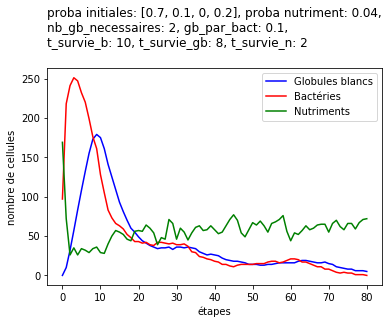

In [16]:
resultsG, resultsB, resultsN = simulate_compte(30,30,150)

x = list(range(len(resultsG)))

plt.plot(x, resultsG, c = 'blue', label = "Globules blancs")
plt.plot(x, resultsB, c = 'red', label = "Bactéries")
plt.plot(x, resultsN, c = 'green', label = "Nutriments")

plt.ylabel("nombre de cellules")
plt.xlabel("étapes")

plt.legend(loc = "best")

plt.title("proba initiales: {}, proba nutriment: {},\nnb_gb_necessaires: {}, gb_par_bact: {},\nt_survie_b: {}, t_survie_gb: {}, t_survie_n: {}\n".format(proba, proba_apparition_nutriments, nb_gb_necessaires, gb_par_bact, t_survie_b, t_survie_gb, t_survie_n),
         loc = 'left')

plt.show()

In [20]:
def simulate(l, h, nbsteps):
    mat = matrice(l, h)
    t = matrice(l, h, True)
    
    results = [mat]
    
    for i in range(nbsteps):
        mat = next_step_matrice(mat, t)
        results.append(mat)
        
    return results

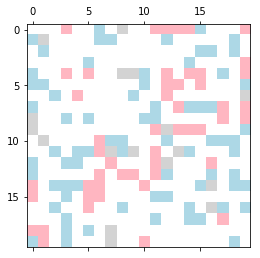

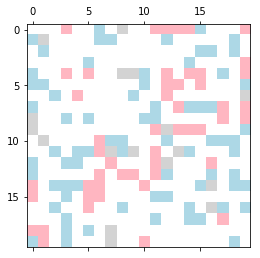

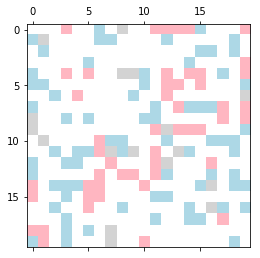

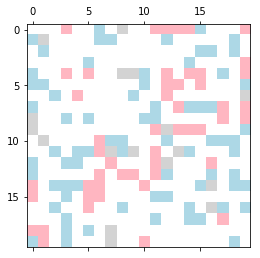

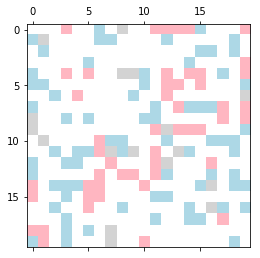

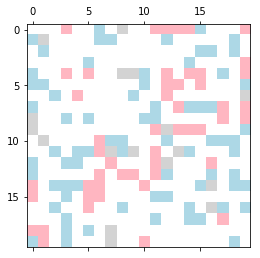

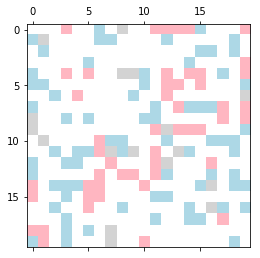

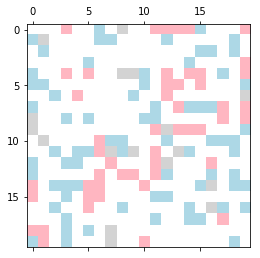

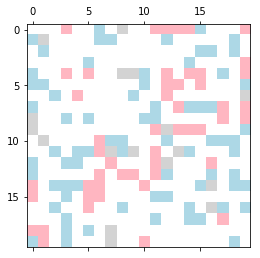

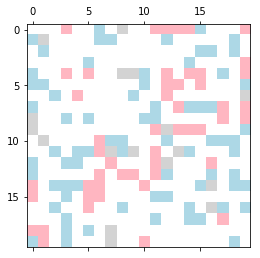

In [44]:
nbsteps = 10

results = simulate(20, 20, nbsteps)

fig = plt.figure()

ims = []

for i in range(nbsteps):
    im = plt.matshow(results[i], cmap = cmap)
    ims.append([im])

for im in ims:
    plt.show(im)
    
#ani = matplotlib.animation.ArtistAnimation(fig, ims, blit = True)
#HTML(ani.to_html5_video())